In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

/tmp/ipykernel_57/1624994282.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Comparison of Stan model to kaggle data analysis:

### Read in Data:

In [32]:
data = pd.read_csv("CarPrice_Assignment.csv")
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


### Data Preprocessing (same as kaggle analysis):

In [33]:
# Extract brand and model from CarName
data['brand'] = data['CarName'].apply(lambda x: x.split(' ')[0])
data['model'] = data['CarName'].apply(lambda x: ' '.join(x.split(' ')[1:]))

# Define categorical and numerical columns
categorical_columns = ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
                       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'brand', 'model']
numerical_columns = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
                     'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
                     'peakrpm', 'citympg', 'highwaympg']

# Encoding categorical variables
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Feature engineering
data['power_to_weight_ratio'] = data['horsepower'] / data['curbweight']
for column in numerical_columns:
    data[f'{column}_squared'] = data[column] ** 2
data['log_enginesize'] = np.log(data['enginesize'] + 1)

# Feature scaling
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,curbweight_squared,enginesize_squared,boreratio_squared,stroke_squared,compressionratio_squared,horsepower_squared,peakrpm_squared,citympg_squared,highwaympg_squared,log_enginesize
0,1,3,alfa-romero giulia,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
1,2,3,alfa-romero stelvio,1,0,1,0,2,0,-1.690772,...,6492304,16900,12.0409,7.1824,81.0,12321,25000000,441,729,4.875197
2,3,1,alfa-romero Quadrifoglio,1,0,1,2,2,0,-0.708596,...,7969329,23104,7.1824,12.0409,81.0,23716,25000000,361,676,5.030438
3,4,2,audi 100 ls,1,0,0,3,1,0,0.173698,...,5461569,11881,10.1761,11.5600,100.0,10404,30250000,576,900,4.700480
4,5,2,audi 100ls,1,0,0,3,0,0,0.107110,...,7974976,18496,10.1761,11.5600,64.0,13225,30250000,324,484,4.919981


<Axes: xlabel='price', ylabel='Count'>

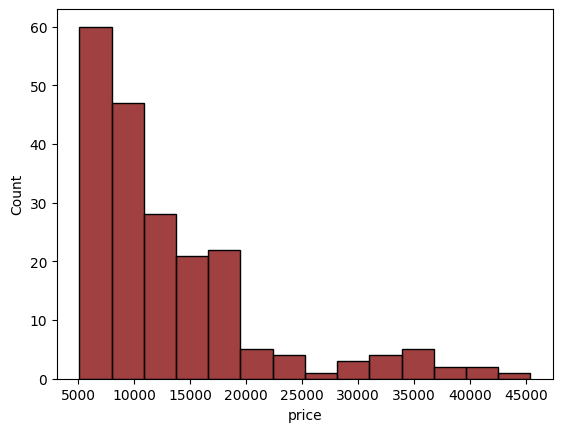

In [4]:
# Inspect the price data
sns.histplot(data.price, color='maroon')

<Axes: xlabel='price', ylabel='Count'>

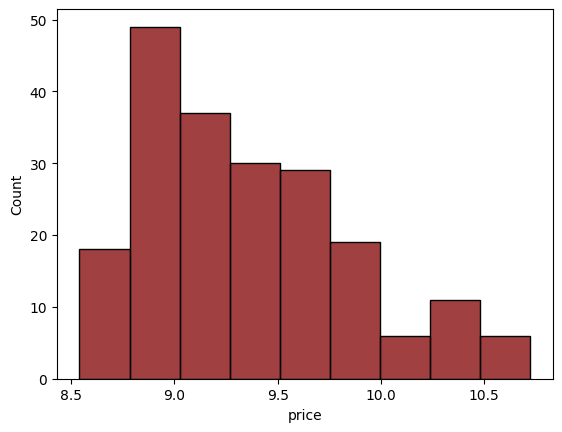

In [5]:
# Price data is not normally distribited, so do log transform
log_price = np.log(data.price)
sns.histplot(log_price, color='maroon')

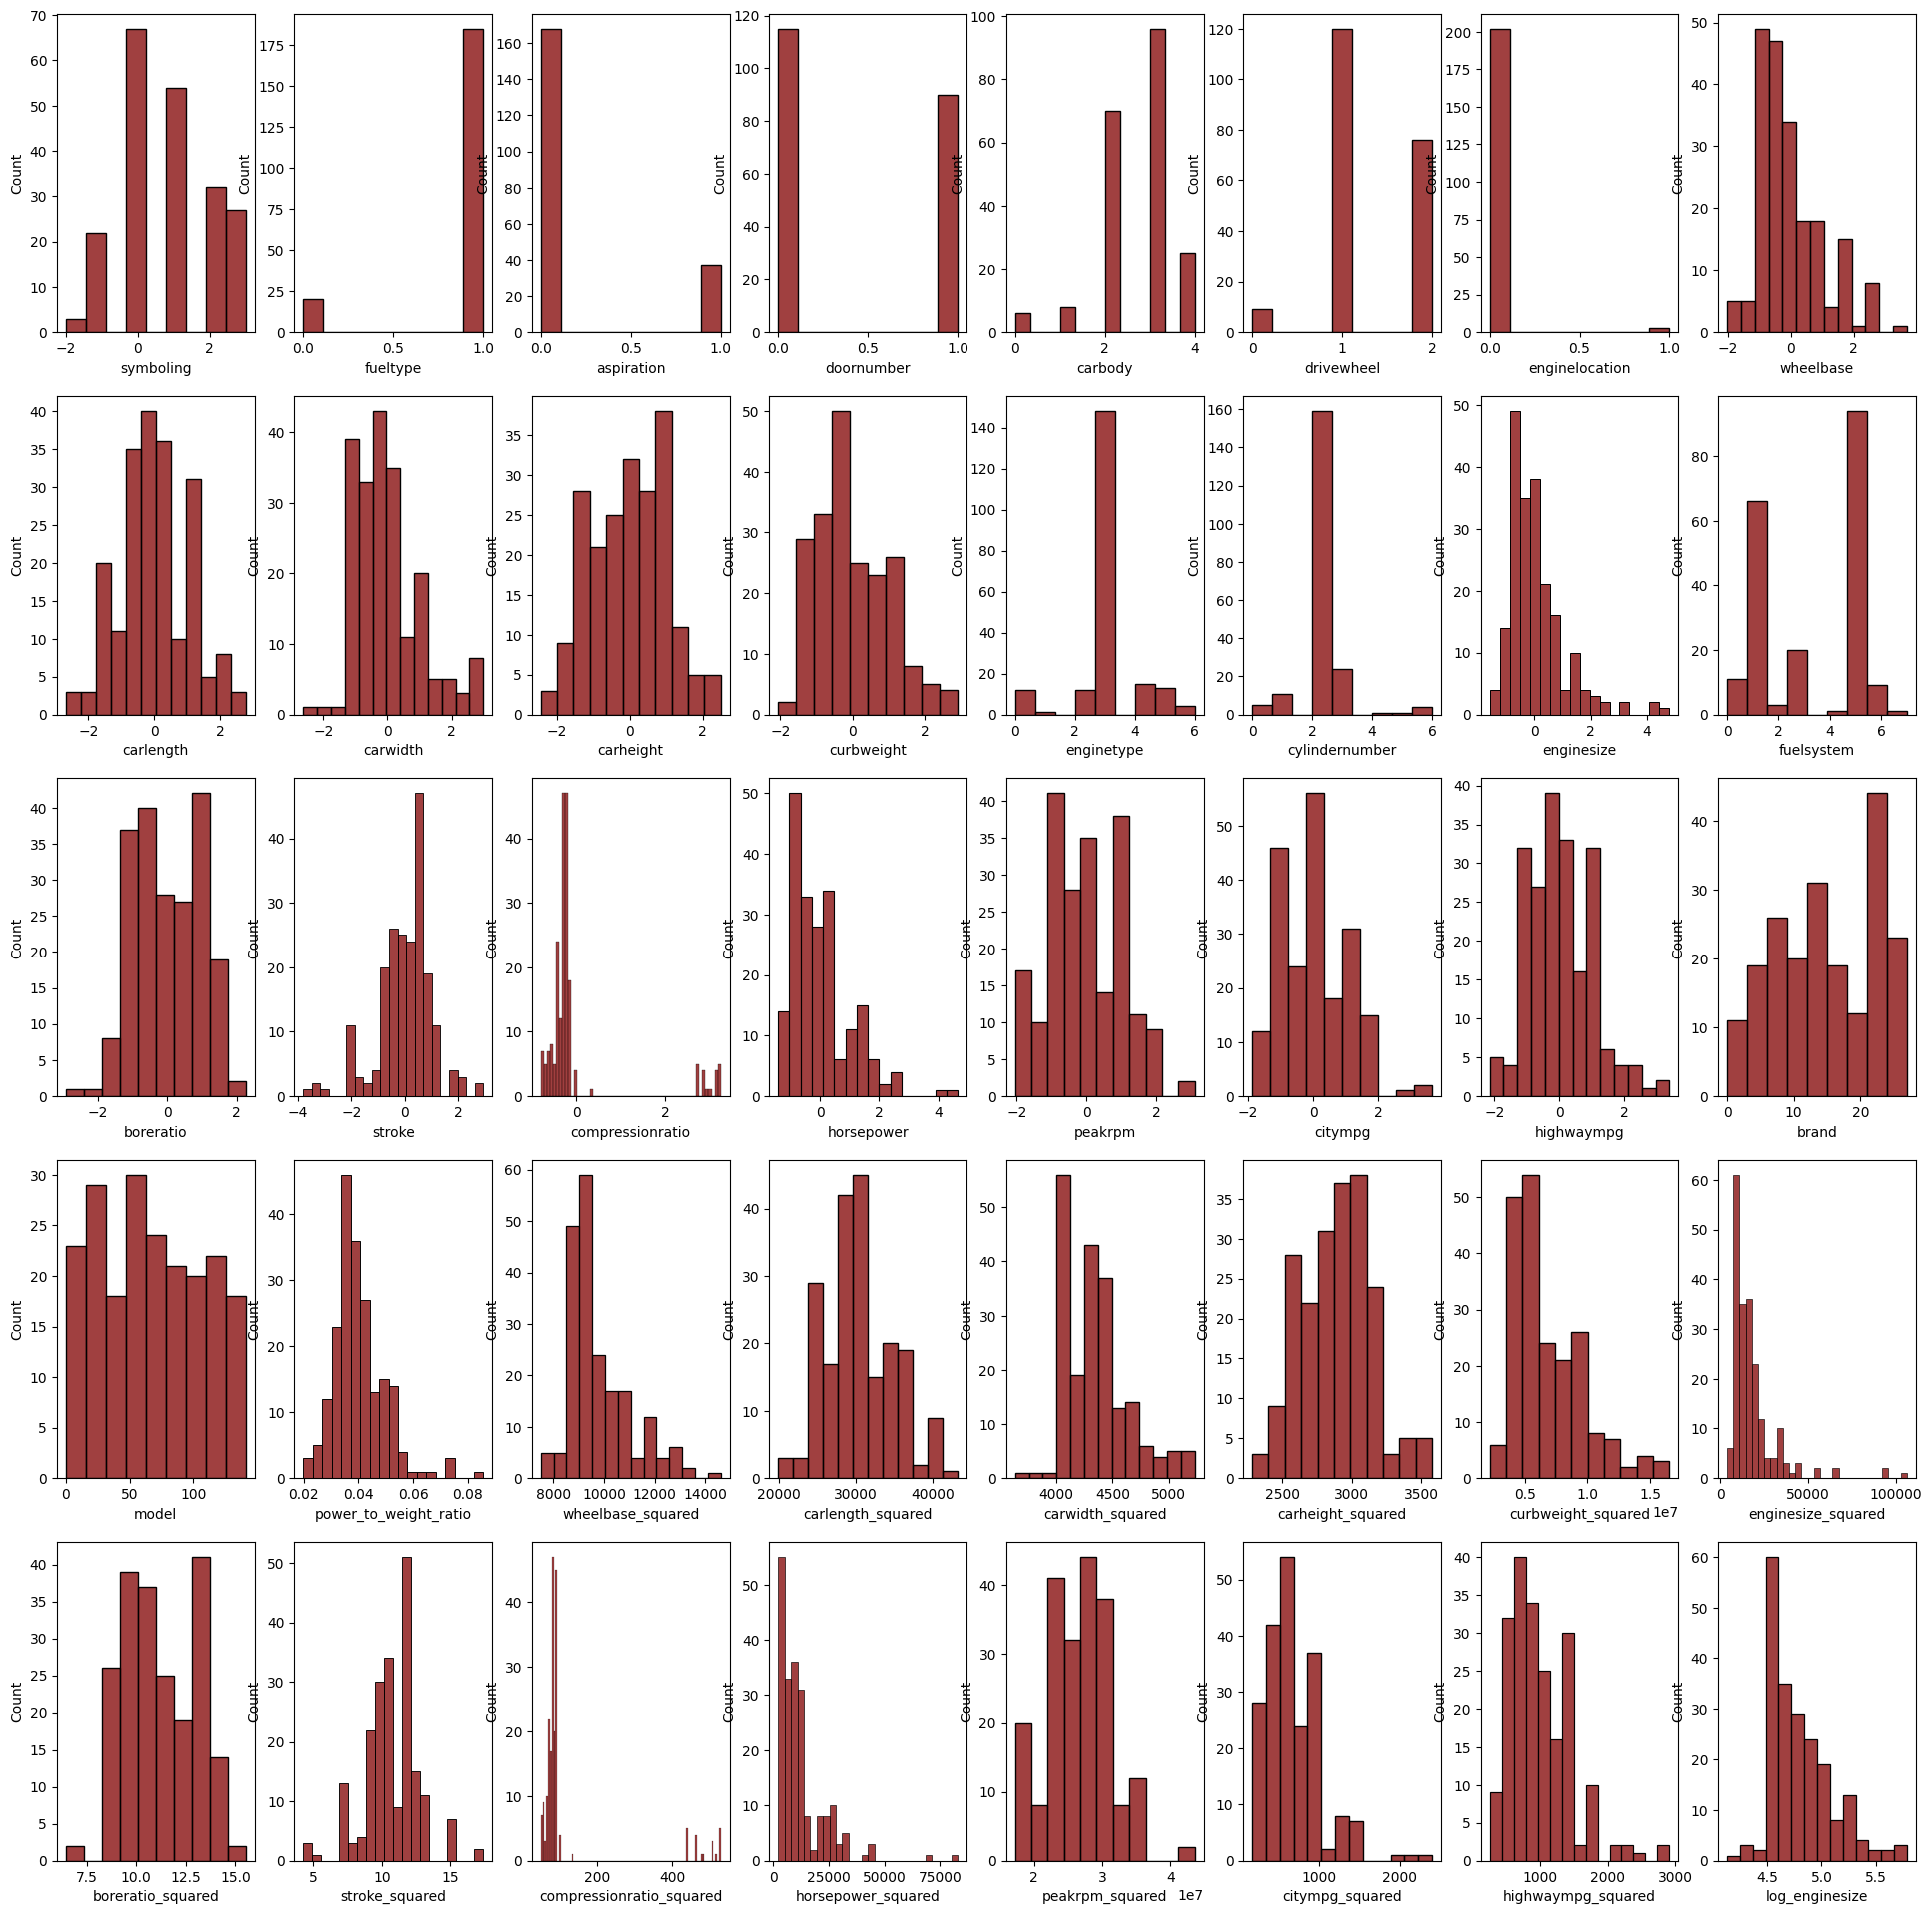

In [6]:
# Inspect histplots of all features
_, ax = plt.subplots(5, 8, figsize=(24, 24))
ax = ax.flatten()
cols = np.array(data.columns)
cols = cols[cols != 'car_ID']
cols = cols[cols != 'CarName']
cols = cols[cols != 'price']
for col, a in zip(cols, ax):
    sns.histplot(data[col], ax=a, color='maroon')

In [7]:
# Use all possible features (don't use squared or logged features that kaggle analysis uses, this makes model not converge)
use_data = data.iloc[:, :29].drop(['car_ID', 'CarName', 'price'], axis=1)
use_data.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'brand', 'model',
       'power_to_weight_ratio'],
      dtype='object')

In [8]:
# Split data into train and test set
X = np.array(use_data)
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Stan Model:

In [9]:
program_code = """
data {
    int<lower=1> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] y;
    int<lower=1> N_test;
    matrix[N_test, K] X_test;
    real mu1;
    real mu2;
    real mu3;
    real sd1;
    real sd2;
    real sd3;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ normal(mu1, sd1);
    alpha ~ normal(mu2, sd2);
    beta ~ normal(mu2, sd3);

    // Likelihood
    y ~ normal(alpha + X * beta, sigma);
}

generated quantities {
    array[N] real gen_y;
    gen_y = normal_rng(alpha + X * beta, sigma);

    array[N_test] real pred_y;
    pred_y = normal_rng(alpha + X_test * beta, sigma);
}
"""

In [10]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test,
    'mu1': 0, #mu and sd are for testing different priors
    'mu2': 9.2,
    'mu3': 9.2,
    'sd1': 10,
    'sd2': 2,
    'sd3': 2
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (1000/12000)
Sampling:  10% (1200/12000)
Sampling:  12% (1400/12000)
Sampling:  13% (1600/12000)
Sampling:  15% (1800/12000)
Sampling:  17% (2000/12000)
Sampling:  19% (2300/12000)
Sampling:  21% (2500/12000)
Sampling:  23% (2800/12000)
Sampling:  26% (3100/12000)
Sampling:

In [11]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,alpha,beta.1,...,pred_y.32,pred_y.33,pred_y.34,pred_y.35,pred_y.36,pred_y.37,pred_y.38,pred_y.39,pred_y.40,pred_y.41
draws,,,,,,,,,,,,,,,,,,,,,
0,-34.192205,0.990517,0.015654,8.0,255.0,0.0,46.720105,0.153275,7.968510,0.010111,...,8.946216,8.785246,9.902924,8.867000,10.154738,9.388627,9.241847,8.424184,9.793026,9.102059
1,-43.277175,0.923329,0.017008,8.0,255.0,0.0,51.282185,0.155447,7.721864,-0.012068,...,8.834901,9.042396,9.824421,9.373433,10.353276,9.225593,9.437588,8.409649,9.122693,9.094561
2,-36.951175,0.993949,0.021972,7.0,127.0,0.0,55.398611,0.160512,8.541634,-0.018514,...,8.709144,8.920189,10.105052,9.117089,10.144491,9.621200,9.759203,8.528545,9.464453,8.925680
3,-41.145020,0.993956,0.019739,8.0,255.0,0.0,57.336306,0.152501,7.289406,0.022044,...,8.862126,8.969771,9.830620,9.374912,9.854474,9.306565,9.302129,9.079578,9.516143,8.855919
4,-38.873073,0.969493,0.015654,8.0,255.0,0.0,48.158584,0.162803,7.709380,0.019447,...,8.468465,8.696847,9.671303,8.915581,10.195758,9.059718,9.316612,8.775408,9.545571,8.723444


In [12]:
regression_summary = az.summary(regression_fit)
regression_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.154,0.010,0.136,0.171,0.000,0.000,8087.0,5833.0,1.0
alpha,7.951,0.383,7.239,8.664,0.006,0.005,3531.0,4436.0,1.0
beta[0],-0.001,0.017,-0.033,0.031,0.000,0.000,6597.0,5809.0,1.0
beta[1],1.288,0.404,0.520,2.038,0.007,0.005,3401.0,4385.0,1.0
beta[2],0.083,0.054,-0.019,0.184,0.001,0.001,5075.0,6372.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_y[36],9.267,0.170,8.941,9.576,0.002,0.001,8057.0,8069.0,1.0
pred_y[37],9.320,0.177,8.993,9.656,0.002,0.001,8652.0,8181.0,1.0
pred_y[38],8.744,0.166,8.436,9.066,0.002,0.001,7265.0,7366.0,1.0
pred_y[39],9.514,0.164,9.211,9.834,0.002,0.001,8415.0,7801.0,1.0


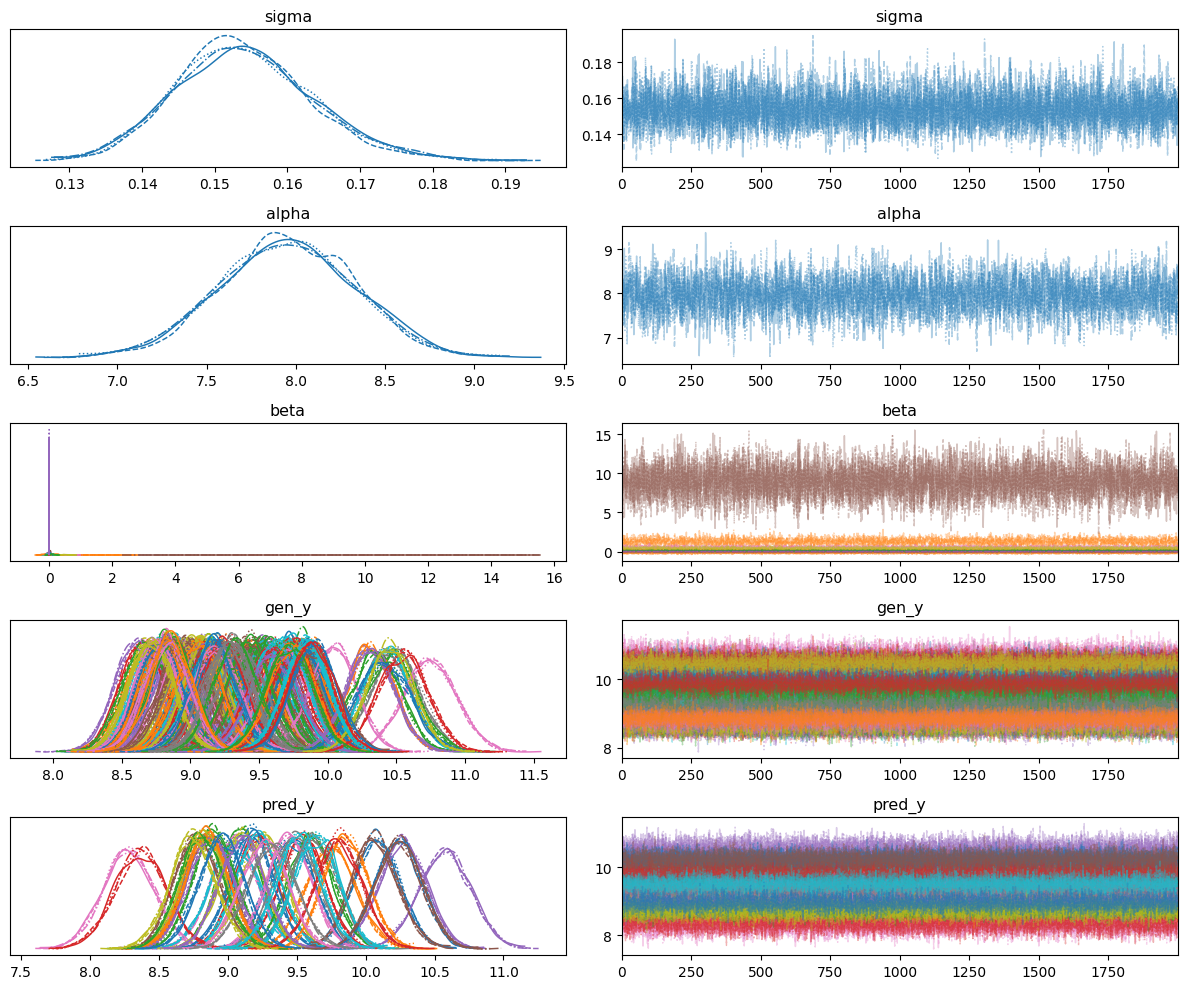

In [13]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

<Axes: ylabel='Density'>

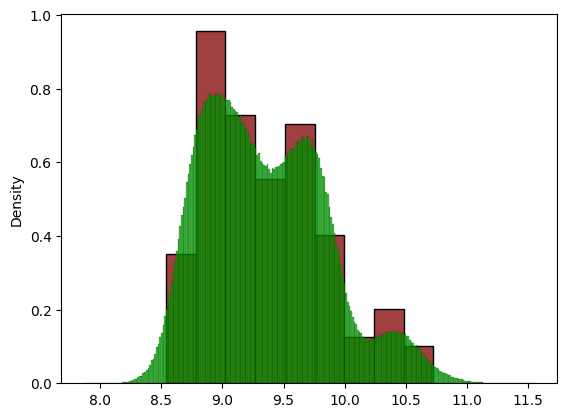

In [14]:
# Marginal Check (Generative)
sns.histplot(y_train, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 35:199].values.flatten(), stat='density', color='#00AA00')

<Axes: ylabel='Density'>

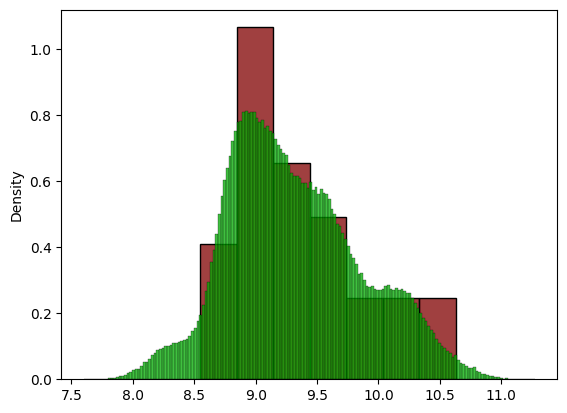

In [15]:
# Marginal Check (Predictive)
sns.histplot(y_test, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 199:].values.flatten(), stat='density', color='#00AA00')

In [16]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.13998408451915584
R2-Score: 0.9209521711178795


In [17]:
# Predictive Performance
preds = regression_fit.__getitem__('pred_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_test)**2))
r2 = r2_score(y_test, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.1845884442284185
R2-Score: 0.8744205629899209


In [18]:
# Betas (check which have the most influence)
betas = regression_fit.__getitem__('beta')
betas_mean = betas.mean(axis=1)
betas_mean

array([-1.04171579e-03,  1.28847693e+00,  8.30623205e-02, -6.67972658e-02,
       -6.60188228e-02,  3.57301791e-02,  5.23424832e-01,  2.69299320e-02,
        1.83635203e-02,  5.36715137e-02,  3.13326117e-02,  2.33629415e-01,
        1.29537464e-02, -1.57048620e-02,  3.27501232e-02,  3.39361865e-02,
        8.23783741e-03, -1.72859773e-02,  4.38445251e-01, -5.76572632e-02,
        2.03859238e-02, -1.79419363e-01,  9.00748845e-02, -9.83310862e-03,
        5.03973609e-04,  8.95605446e+00])

#### Removing some features

<Axes: xlabel='price', ylabel='Count'>

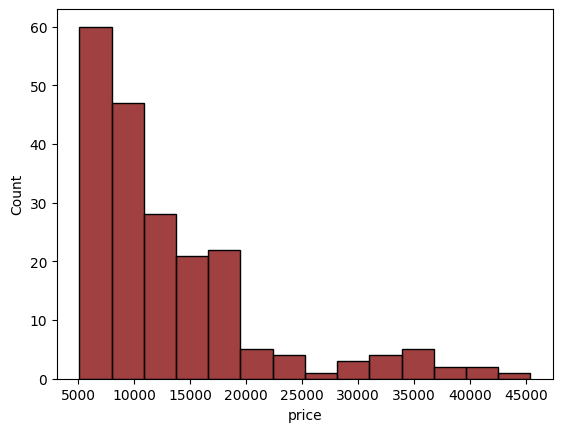

In [35]:
inspect_data = data.iloc[:, :29].drop(['car_ID', 'CarName', 'symboling','doornumber','carbody','cylindernumber','stroke','horsepower','citympg','brand','highwaympg','boreratio','wheelbase','aspiration'], axis=1)
sns.histplot(inspect_data.price, color='maroon')

<Axes: xlabel='price', ylabel='Count'>

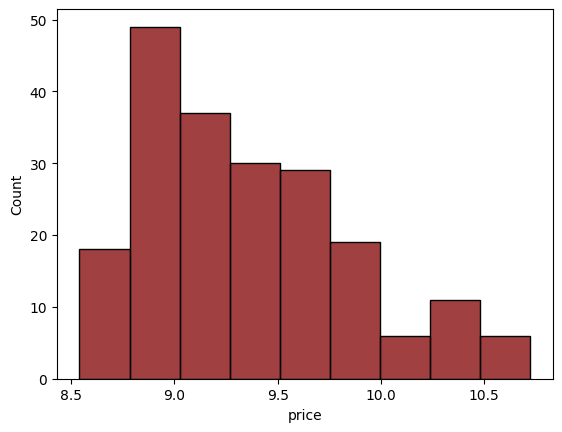

In [36]:
log_price = np.log(inspect_data.price)
sns.histplot(log_price, color='maroon')

In [19]:
# Remove uninfluential features
use_data = use_data.drop(['symboling','doornumber','carbody','cylindernumber','stroke','horsepower','citympg','brand','highwaympg','boreratio','wheelbase','aspiration'], axis=1)
use_data.columns

Index(['fueltype', 'drivewheel', 'enginelocation', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'enginesize', 'fuelsystem',
       'compressionratio', 'peakrpm', 'model', 'power_to_weight_ratio'],
      dtype='object')

In [20]:
# Split data into train and test set
X = np.array(use_data)
y = np.array(log_price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Stan Model:

In [158]:
program_code = """
data {
    int<lower=1> N;
    int<lower=0> K;
    matrix[N, K] X;
    vector[N] y;
    int<lower=1> N_test;
    matrix[N_test, K] X_test;
    real mu1;
    real mu2;
    real mu3;
    real sd1;
    real sd2;
    real sd3;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[K] beta;
}

model {
    // Priors
    sigma ~ inv_gamma(mu1, sd1);
    alpha ~ normal(mu2, sd2);
    beta ~ normal(mu2, sd3);

    // Likelihood
    y ~ normal(alpha + X * beta, sigma);
}

generated quantities {
    array[N] real gen_y;
    gen_y = normal_rng(alpha + X * beta, sigma);

    array[N_test] real pred_y;
    pred_y = normal_rng(alpha + X_test * beta, sigma);
}
"""

In [168]:
# Prepare data in Stan friendly format
data_dict = {
    'N': X_train.shape[0],
    'K': X_train.shape[1],
    'X': X_train,
    'y': y_train,
    'N_test': X_test.shape[0],
    'X_test': X_test,
    'mu1': 1, #mu and sd are for testing different priors
    'mu2': 9.4,
    'mu3': 9.4,
    'sd1': 1,
    'sd2': 3,
    'sd3': 3
}

# Compile model
regression_model = stan.build(program_code, data=data_dict)

# Sample 4 x 2000 random draws from the posterior
regression_fit = regression_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%


Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   2% (203/12000)
Sampling:   3% (402/12000)
Sampling:   5% (601/12000)
Sampling:   8% (900/12000)
Sampling:  10% (1200/12000)
Sampling:  13% (1600/12000)
Sampling:  18% (2100/12000)
Sampling:  21% (2500/12000)
Sampling:  26% (3100/12000)
Sampling:  46% (5500/12000)
Sampling:  65% (7800/12000)
Sampling:  84% (10100/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust 

In [169]:
regression_results = regression_fit.to_frame()
regression_results.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,alpha,beta.1,...,pred_y.32,pred_y.33,pred_y.34,pred_y.35,pred_y.36,pred_y.37,pred_y.38,pred_y.39,pred_y.40,pred_y.41
draws,,,,,,,,,,,,,,,,,,,,,
0,91.456960,0.470266,0.027020,7.0,127.0,0.0,-77.939026,0.203350,8.653848,0.189176,...,8.669288,8.438106,9.936078,9.292152,10.036696,9.275074,9.328132,8.489571,9.552509,9.122129
1,90.856786,0.977543,0.024247,7.0,127.0,0.0,-83.080767,0.194382,8.078201,0.678494,...,8.626073,8.803956,9.880947,8.759534,10.467504,9.448296,8.987299,9.109125,9.604721,8.840767
2,92.406786,0.997343,0.027329,8.0,255.0,0.0,-83.263588,0.197589,7.833993,0.970585,...,9.107029,9.082599,9.917704,9.224344,10.192512,9.420637,9.629245,8.573375,9.717862,9.268514
3,88.941515,0.752623,0.031761,7.0,127.0,0.0,-82.026028,0.224465,8.657891,-0.018112,...,8.708149,8.790731,9.763568,9.367137,9.917868,8.903018,8.845487,8.916727,9.179851,8.994537
4,89.874179,0.980139,0.027020,7.0,127.0,0.0,-84.494443,0.197853,8.914984,0.189843,...,8.876153,8.991719,10.239706,9.003303,10.065240,9.046418,9.238335,8.785546,9.873119,8.930369


In [170]:
regression_summary = az.summary(regression_fit)
regression_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.208,0.013,0.184,0.234,0.000,0.000,8225.0,5552.0,1.0
alpha,8.326,0.352,7.705,9.020,0.007,0.005,2722.0,3960.0,1.0
beta[0],0.470,0.371,-0.238,1.154,0.007,0.005,2869.0,3880.0,1.0
beta[1],0.061,0.041,-0.016,0.138,0.000,0.000,7283.0,5420.0,1.0
beta[2],0.611,0.150,0.329,0.897,0.002,0.001,5802.0,5671.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_y[36],9.256,0.221,8.833,9.664,0.003,0.002,6983.0,6878.0,1.0
pred_y[37],9.314,0.228,8.896,9.756,0.003,0.002,8159.0,8014.0,1.0
pred_y[38],8.758,0.213,8.362,9.157,0.002,0.002,8241.0,8226.0,1.0
pred_y[39],9.585,0.216,9.188,9.994,0.002,0.002,7806.0,7694.0,1.0


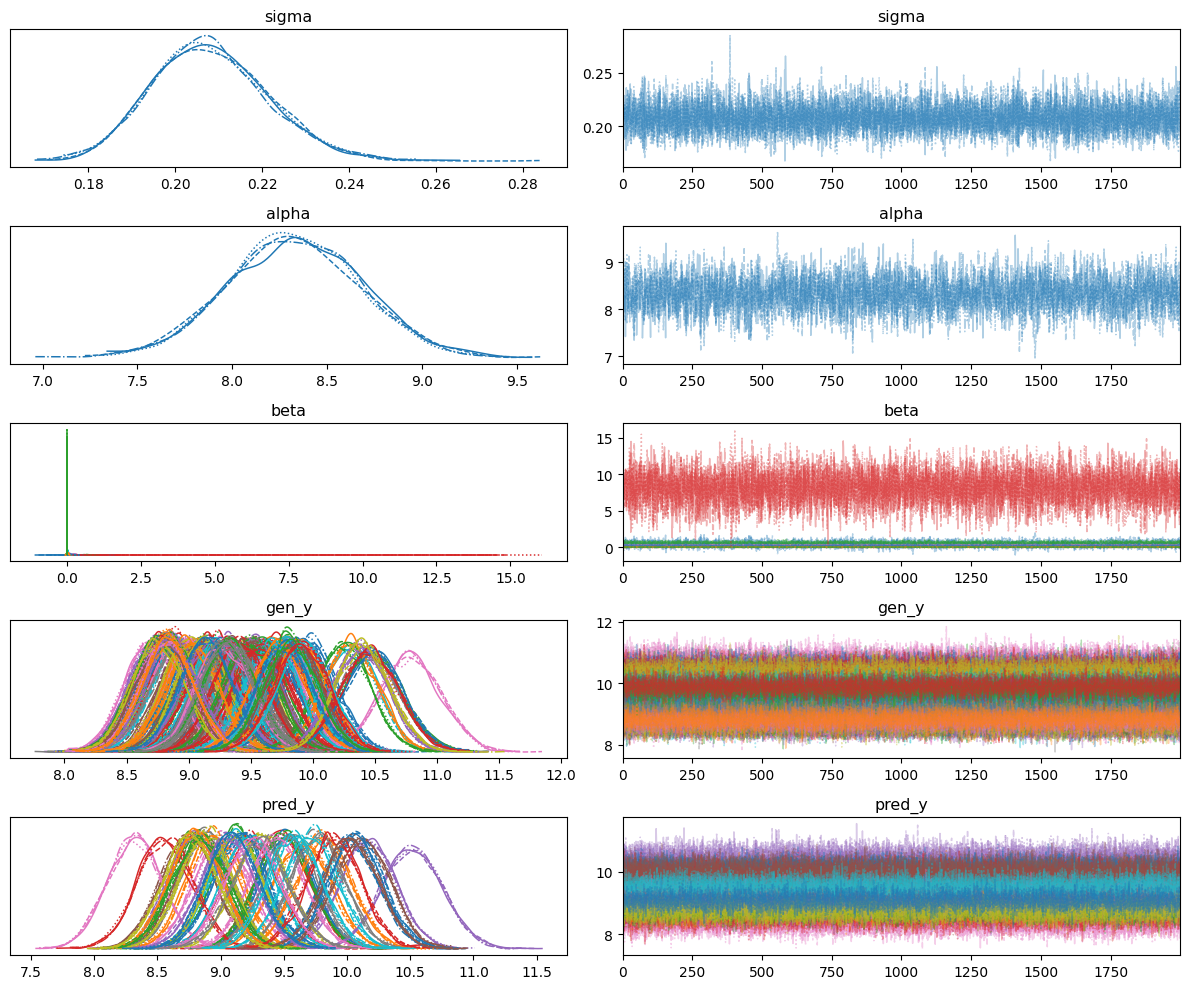

In [171]:
_ = az.plot_trace(regression_fit)
plt.tight_layout()

<Axes: ylabel='Density'>

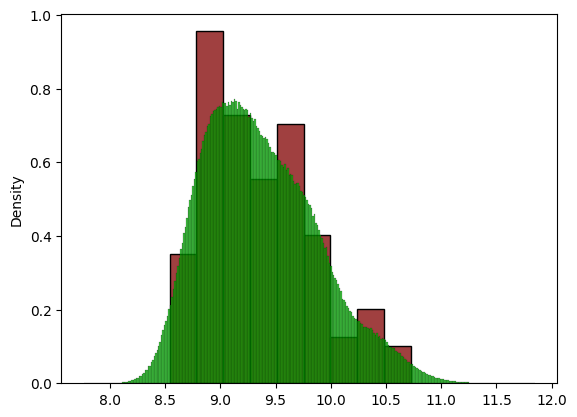

In [172]:
# Marginal Check (Generative)
sns.histplot(y_train, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 35:199].values.flatten(), stat='density', color='#00AA00')

<Axes: ylabel='Density'>

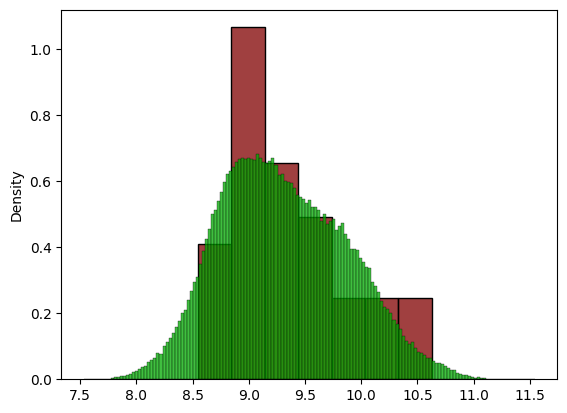

In [173]:
# Marginal Check (Predictive)
sns.histplot(y_test, color='maroon', stat='density')
sns.histplot(regression_results.iloc[:, 199:].values.flatten(), stat='density', color='#00AA00')

In [174]:
# Generative Performance
preds = regression_fit.__getitem__('gen_y')
preds_mean = preds.mean(axis=1)
rmse = np.sqrt(np.mean((preds_mean - y_train)**2))
r2 = r2_score(y_train, preds_mean)
print("RMSE:", rmse)
print("R2-Score:", r2)

RMSE: 0.16333243890722593
R2-Score: 0.8923838335175552


In [175]:
# Betas (check which have the most influence)
betas = regression_fit.__getitem__('beta')
betas_mean = betas.mean(axis=1)
betas_mean

array([4.69562483e-01, 6.09275249e-02, 6.11278271e-01, 4.05022116e-02,
       8.64370640e-02, 1.06499120e-02, 2.50137816e-01, 2.00630466e-02,
       1.63682187e-02, 2.78063859e-02, 1.65355560e-01, 2.50734635e-02,
       5.17144583e-04, 8.07692995e+00])